In [4]:
# Necessary Libraries
import re
import numpy as np

# Necessary Seed
np.random.seed(42)

In [5]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [6]:
# Define the function to tokenize the text
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [7]:
tokens = tokenize(text)

In [8]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

word_to_id, id_to_word = mapping(tokens)
print(word_to_id)

{'algorithms': 0, 'build': 1, 'needed': 2, 'intelligence': 3, 'machine': 4, 'as': 5, 'predictions': 6, 'without': 7, 'difficult': 8, 'programmed': 9, 'conventional': 10, 'order': 11, 'and': 12, 'perform': 13, 'such': 14, 'to': 15, 'do': 16, 'tasks': 17, 'through': 18, 'on': 19, 'known': 20, 'applications': 21, 'or': 22, 'study': 23, 'decisions': 24, 'it': 25, 'seen': 26, 'wide': 27, 'a': 28, 'mathematical': 29, 'explicitly': 30, 'being': 31, 'develop': 32, 'improve': 33, 'subset': 34, 'infeasible': 35, 'experience': 36, 'training': 37, 'artificial': 38, 'learning': 39, 'that': 40, 'make': 41, 'sample': 42, 'so': 43, 'automatically': 44, 'email': 45, 'based': 46, 'filtering': 47, 'vision': 48, 'used': 49, 'variety': 50, 'the': 51, 'of': 52, 'model': 53, 'is': 54, 'computer': 55, 'in': 56, 'data': 57, 'are': 58, 'where': 59}


In [9]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable



In [10]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [11]:
def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [12]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [13]:
X.shape

(330, 60)

In [14]:
y.shape

(330, 60)

## Defining The Required Model

In [15]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [16]:
model = init_network(len(word_to_id), 10)

In [17]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [18]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

In [19]:
(X @ model["w1"]).shape

(330, 10)

In [20]:
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

In [21]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [22]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

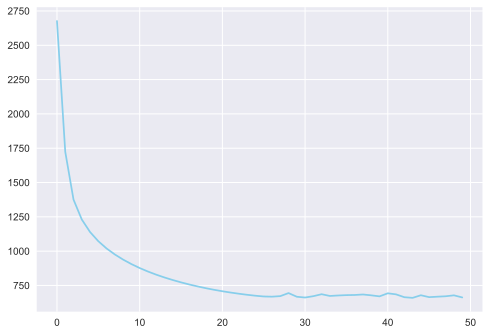

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn-v0_8")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [31]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
is
build
are
so
intelligence
algorithms
the
of
learning
to
used
sample
vision
known
computer
study
subset
seen
filtering
training
on
that
order
needed
perform
based
mathematical
model
difficult
a
email
variety
where
predictions
automatically
develop
data
tasks
such
programmed
without
do
wide
or
and
in
conventional
experience
artificial
infeasible
improve
as
make
through
applications
decisions
it
being
explicitly


In [32]:
model["w1"]

array([[-1.76486720e+00, -2.78577446e-01, -1.35709806e+00,
         6.64058376e-01,  1.79709155e-01, -2.73535583e-01,
         7.42102554e-01,  8.79481532e-02, -3.39739668e-01,
        -6.76167462e-01],
       [-2.58469719e-01,  8.11367734e-01, -8.32530628e-02,
        -1.02535133e+00, -8.62057791e-01, -1.13231366e+00,
        -2.00512550e-01,  2.08659189e+00, -1.37371406e+00,
        -1.50570979e+00],
       [ 1.18546229e+00, -1.15023477e+00, -8.59805149e-01,
        -1.78594152e+00, -9.35200999e-02,  1.08775548e+00,
        -1.37140625e+00,  7.31023548e-02, -1.34840551e+00,
        -1.08336158e+00],
       [-1.81142551e+00,  9.81514188e-01,  8.45513578e-02,
        -1.08080137e+00,  6.11952945e-02, -1.60204473e+00,
         9.31336345e-01,  5.51861260e-01, -9.37772130e-01,
        -1.11138869e+00],
       [ 4.43317631e-01, -1.88521719e-01,  6.74946223e-01,
        -1.05301132e+00, -8.24332642e-01,  3.76360544e-02,
         1.96674123e-03,  6.54927268e-01, -9.82699790e-01,
        -2.

In [33]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [36]:
get_embedding(model, "machine")

array([ 4.43317631e-01, -1.88521719e-01,  6.74946223e-01, -1.05301132e+00,
       -8.24332642e-01,  3.76360544e-02,  1.96674123e-03,  6.54927268e-01,
       -9.82699790e-01, -2.27260176e+00])